Partiendo de 2000 datos de entrenamiento, 1000 de validación y 2000 de prueba extender la BD por medio de transformaciones 

In [17]:
!pip install gdown #Instala una librería para descargar archivos de Google Drive
!gdown --id 1YeHqH7Gbypust6sZT2ehl8CUE9ELHQYC #Descarga el dataset que está en el Drive del Prof. Pereira
!unzip cats_vs_dogs_small.zip #Descomprime el archivo del dataset
from IPython.display import Image #Librería para visualizar imágenes en Jupyter

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: cats_vs_dogs_small/test/cat/1500.jpg  
  inflating: cats_vs_dogs_small/test/cat/1501.jpg  
  inflating: cats_vs_dogs_small/test/cat/1502.jpg  
  inflating: cats_vs_dogs_small/test/cat/1503.jpg  
  inflating: cats_vs_dogs_small/test/cat/1504.jpg  
  inflating: cats_vs_dogs_small/test/cat/1505.jpg  
  inflating: cats_vs_dogs_small/test/cat/1506.jpg  
  inflating: cats_vs_dogs_small/test/cat/1507.jpg  
  inflating: cats_vs_dogs_small/test/cat/1508.jpg  
  inflating: cats_vs_dogs_small/test/cat/1509.jpg  
  inflating: cats_vs_dogs_small/test/cat/1510.jpg  
  inflating: cats_vs_dogs_small/test/cat/1511.jpg  
  inflating: cats_vs_dogs_small/test/cat/1512.jpg  
  inflating: cats_vs_dogs_small/test/cat/1513.jpg  
  inflating: cats_vs_dogs_small/test/cat/1514.jpg  
  inflating: cats_vs_dogs_small/test/cat/1515.jpg  
  inflating: cats_vs_dogs_small/test/cat/1516.jpg  
  inflating: cats_vs_dogs_small/test/cat/1517.jpg  
  i

In [18]:
!cp cats_vs_dogs_small/train/Cat/665.jpg cats_vs_dogs_small/train/Cat/666.jpg
!cp cats_vs_dogs_small/train/Cat/834.jpg cats_vs_dogs_small/train/Cat/835.jpg

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Transformaciones que se aplicarán a las imágenes: Desplazamiento aleatorio horizontal, rotación aleatoria de máximo 0.1 radianes y una reducción de máximo 0.2

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

original_dir=r"/content/drive/drive/u/0/shared-with-me"
new_base_dir=r"/content/drive/u/0/shared-with-me/cats_vs_dogs_small"

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [21]:
new_base_dir=r"cats_vs_dogs_small"

In [22]:
"""
import os, shutil
def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        dir = new_base_dir+"/"+subset_name+"/"+category
        fnames = [f"{original_dir}/{category}/{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            print(fname)
            print(dir)
            shutil.copy(fname,dir)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)
"""

'\nimport os, shutil\ndef make_subset(subset_name, start_index, end_index):\n    for category in ("Cat", "Dog"):\n        dir = new_base_dir+"/"+subset_name+"/"+category\n        fnames = [f"{original_dir}/{category}/{i}.jpg" for i in range(start_index, end_index)]\n        for fname in fnames:\n            print(fname)\n            print(dir)\n            shutil.copy(fname,dir)\n\nmake_subset("train", start_index=0, end_index=1000)\nmake_subset("validation", start_index=1000, end_index=1500)\nmake_subset("test", start_index=1500, end_index=2500)\n'

Ajustando los datos para que todas las imágenes tengan la misma resolución y se procesen en lotes de 32 por cada pasada del algoritmo descenso de gradiente

In [23]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Otros ajustes a los datos y verificación del tensor que contiene los datos

In [24]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [25]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Visualización de una imagen con todas las combinaciones de las tres transformaciones definidas, a saber: desplazamiento horizontal, rotacion de 0.1 radianes y Zoom de 0.2 

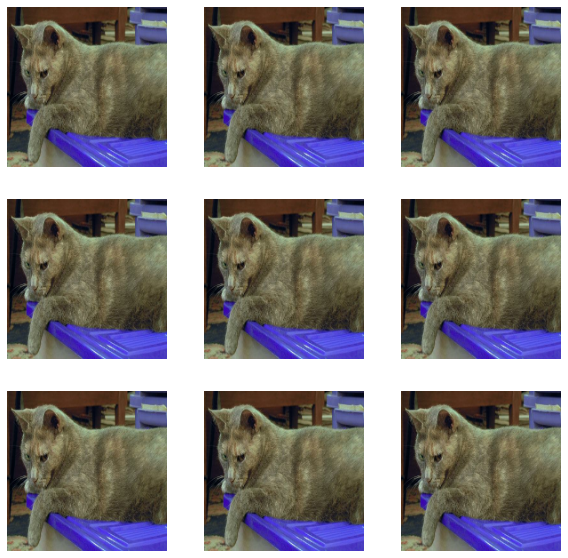

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Arquitectura de la red neuronal y definición del algoritmo de descenso de gradiente, función de pérdida y métrica de evaluación

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Fase de entrenamiento 

In [28]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset)

Epoch 1/50
63/63 [==============================] - 7s 88ms/step - loss: 0.7100 - accuracy: 0.5040 - val_loss: 0.6899 - val_accuracy: 0.5450
Epoch 2/50
63/63 [==============================] - 8s 122ms/step - loss: 0.7090 - accuracy: 0.5295 - val_loss: 0.6826 - val_accuracy: 0.5160
Epoch 3/50
63/63 [==============================] - 6s 90ms/step - loss: 0.6791 - accuracy: 0.6060 - val_loss: 0.6691 - val_accuracy: 0.5880
Epoch 4/50
63/63 [==============================] - 5s 73ms/step - loss: 0.6605 - accuracy: 0.6075 - val_loss: 0.6481 - val_accuracy: 0.6100
Epoch 5/50
63/63 [==============================] - 5s 73ms/step - loss: 0.6425 - accuracy: 0.6430 - val_loss: 0.6600 - val_accuracy: 0.5920
Epoch 6/50
63/63 [==============================] - 5s 73ms/step - loss: 0.6104 - accuracy: 0.6895 - val_loss: 0.7071 - val_accuracy: 0.6200
Epoch 7/50
63/63 [==============================] - 5s 73ms/step - loss: 0.5982 - accuracy: 0.6935 - val_loss: 0.6321 - val_accuracy: 0.6260
Epoch 8/50
6

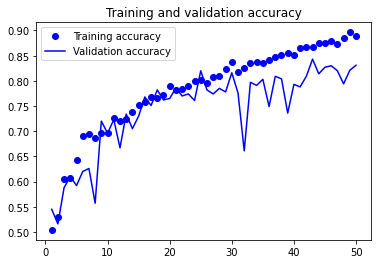

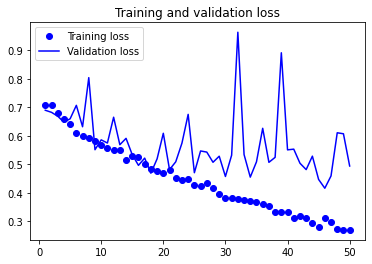

In [29]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Ejercicio:
---------
1. Disminuya el número de épocas ¿Hay mejora?
2. Probar con regularización además del dropout ¿Hay mejora?